In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import netCDF4 as nc
from datetime import datetime, timedelta

from scipy.interpolate import interp1d

import sys
sys.path.append('../src/')

In [2]:
from TamocWrapper import run_tamoc_sbm, parse_tamoc_sbm_results, setup_ambient_profile, get_bubble_diameter
from FateModel import run_eulerian, run_one_year, run_ensemble
from PlotterFunctions import plot_massbalance, plot_parameter_scan

In [3]:
def get_kw(U):
    # Parameterisation of mass transfer coefficient in terms of windspeed
    # Taken from Orr et al. (2017)
    # https://doi.org/10.5194/gmd-10-2169-2017
    Sc = 677     # Schmidt number for methane in water
    a = 6.97e-7  # Empirical constant
    return a * U**2 * (Sc/660)**(-0.5)

In [4]:
# Dictionary of depths for the three different stations
depth_dict = {
    1 : 65,
    2 : 106,
    3 : 303,
}

# Single Bubble Model (SBM)

We run the SBM, and plot some output, as an example. These results correspond to Figure 5 in the paper.

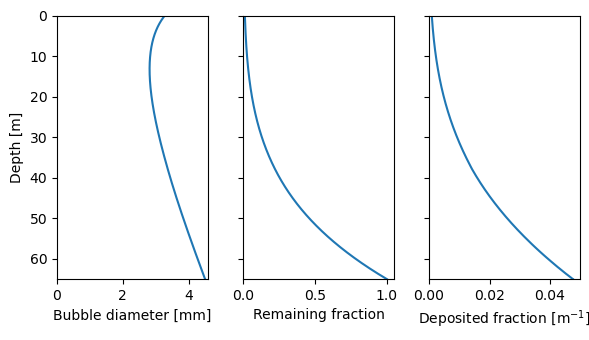

In [5]:
##########################
#### Model parameters ####
##########################

# Select station here (1, 2 or 3)
case = 1
# Initial bubble diameter, in meters
d0 = 4.5e-3
# Release depth, in meters (positive downwards)
z0 = depth_dict[case] # Look up depth in dictionary and release from sea floor, or change to some other depth



##########################
#### Simulation setup ####
##########################

# Load water column data
# (temperature, salinity, diffusivity)
ds = nc.Dataset(f'../data/station{case}/case{case}.nc')

# Note on array slicing below
# Z-coordinates are stored with time dimension, but remain constant, hence leading zero.
# To re-order data to run from surface and down we use ::-1
# The variables have four dimensions, where the last two have length 1, hence the two last zeros.

# Choose a time index
it = 1500
# Load z-coordinates for cell faces and cell centers
z_gotm  = np.array(np.abs(ds.variables['z' ][0,::-1,0,0]))
# Lead temperature, salinity and diffusivity
T_gotm  = np.array(ds.variables['temp'][it,::-1,0,0])
S_gotm  = np.array(ds.variables['salt'][it,::-1,0,0])

# Prepare a profile object used by the TAMOC SBM
profile = setup_ambient_profile(z_gotm, T_gotm, S_gotm)

# The parameter t_hyd is used to switch between "clean" and "dirty" bubble
# mass transfer coefficient. Setting t_hyd to any number larger than the time
# the bubble takes to reach the surface means we use clean bubble mass transfer
t_hyd = np.inf

# Run TAMOC SBM
bub, sbm = run_tamoc_sbm(z0, d0, profile, t_hyd=t_hyd)
# Parse the output of TAMOC to produce profiles of deposited methane,
# and find fraction of methane reaching the surface with bubble
depth, remaining, deposited, direct = parse_tamoc_sbm_results(sbm, z0)
# Calculate bubble diameter from output (mass, temperature, pressure, composition)
z, d = get_bubble_diameter(bub, sbm, profile)



######################
#### Plot results ####
######################

fig, ax = plt.subplots(ncols=3, figsize=(6, 3.5), sharey=True)

ax[0].plot(1000*d, z) # Multiply by 1000 to convert m to mm
ax[1].plot(remaining[:-1], depth)
ax[2].plot(deposited, depth)

# Force all plots to have x-axis starting at zero
for a in ax:
    a.set_xlim(xmin=0)

# Set ylim with seafloor at the bottom and surface at top
ax[0].set_ylim(z0, 0)

# Add labels
ax[0].set_ylabel('Depth [m]')
ax[0].set_xlabel('Bubble diameter [mm]')
ax[1].set_xlabel('Remaining fraction')
ax[2].set_xlabel('Deposited fraction [m$^{-1}$]')
plt.tight_layout()

# Run diffusion model once, and plot mass balance

The plots generated here correspond to Figure 6 in the paper.

Mass balance at end of simulation:
Direct transport to atmosphere:   1.27%
Mass transfer to atmosphere:     86.79%
Dissolved in water column:        0.70%
Biodegraded:                     11.24%

Sum of all mass-compartments:   99.999999983%


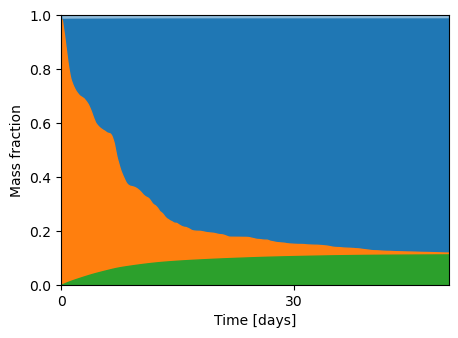

In [6]:
##########################
#### Model parameters ####
##########################

# Select station here (1, 2 or 3)
case = 1
# Initial bubble diameter, in meters
d0 = 4.5e-3
# Release depth, in meters (positive downwards)
z0 = depth_dict[case] # Look up depth in dictionary and release from sea floor
# Biodegradation half-life, in seconds
halflife = 50 * 24*3600



##########################
#### Simulation setup ####
##########################

# Load water column data
# (temperature, salinity, diffusivity)
ds = nc.Dataset(f'../data/station{case}/case{case}.nc')

# Note on array slicing below
# Z-coordinates are stored with time dimension, but remain constant, hence leading zero.
# To re-order data to run from surface and down we use ::-1
# The variables have four dimensions, where the last two have length 1, hence the two last zeros.
# The GOTM run was started on December 25, 2018, 00:00 to give some spin-up time
# Slice away the first seven days (hourly output: remove first 7*24 = 168 timesteps)
# And slice away last timestep, which is January 1, 2010, 00:00
skip = 7*24
# Load z-coordinates for cell faces and cell centers
z_gotm  = np.array(np.abs(ds.variables['z' ][0,::-1,0,0]))
zi_gotm = np.array(np.abs(ds.variables['zi'][0,::-1,0,0]))
# Load timestamps for GOTM data
t_gotm  = np.array(ds.variables['time'][skip:-1])
# Reset time to start at zero
t_gotm = t_gotm - t_gotm[0]
# Lead temperature, salinity and diffusivity
T_gotm  = np.array(ds.variables['temp'][skip:-1,::-1,0,0])
S_gotm  = np.array(ds.variables['salt'][skip:-1,::-1,0,0])
K_gotm  = np.array(ds.variables['nus'][ skip:-1,::-1,0,0])

# Load atmosphere data
# We read this from the GOTM input file for convenience
# but it was originally taken from ERA5
# https://doi.org/10.24381/cds.adbb2d47
df_meteo = pd.read_csv(f'../data/station{case}/meteo_file.dat',
                       delim_whitespace=True, index_col=False, parse_dates=[[0,1]],
                       names=['date', 'time', 'u10', 'v10',  'pressure', 'temp', 'humid', 'cloud'])

# Calculate wind speed and mass-transfer coefficient
windspeed = np.sqrt(df_meteo['u10']**2 + df_meteo['v10']**2)
kw = get_kw(windspeed)
# Keep only the values for 2019
mask = (datetime(2019,1,1,0,0) <= df_meteo['date_time'] ) & (df_meteo['date_time'] < datetime(2020,1,1,0,0))
kw = kw[mask].values
# Calculate matching timestamps, in seconds, where t=0 is 2019.00.00 - 00:00
kw_times =  3600 * np.arange(len(kw))

# Choose start time for the simulation, in seconds since 2019, 1, 1, 00:00
t0 = 0
# Choose a stop time for the simulation (stop time = start time + duration)
Tmax = t0 + 50*24*3600

# Choose diffusion model timestep
dt = 600

# Create grid for Eulerian diffusion-reaction solver
zf, dz = np.linspace(0, z0, 651, retstep=True)
zc = zf[:-1] + dz/2
    
# Interpolate GOTM diffusivity to diffusion solver grid
K = np.zeros((len(t_gotm), len(zf)))
K_times = t_gotm
for it in range(K.shape[0]):
    K[it,:] = np.interp(zf, zi_gotm, K_gotm[it,:])
    
# Create profile for TAMOC simulation
# Look up T and S profiles for start time
# Note: Bubble rise is very fast, and T and S are therefore treated as constant
# during the bubble rise time
it = np.searchsorted(t_gotm, t0)
T_gotm = ds.variables['temp'][it,:,0,0]
S_gotm = ds.variables['salt'][it,:,0,0]
profile = setup_ambient_profile(z_gotm, T_gotm, S_gotm)

# The parameter t_hyd is used to switch between "clean" and "dirty" bubble
# mass transfer coefficient. Setting t_hyd to any number larger than the time
# the bubble takes to reach the surface means we use clean bubble mass transfer
t_hyd = np.inf

# Run TAMOC SBM
bub, sbm = run_tamoc_sbm(z0, d0, profile, t_hyd=t_hyd)
# Parse the output of TAMOC to produce profiles of deposited methane,
# and find fraction of methane reaching the surface with bubble
depth, remaining, deposited, direct = parse_tamoc_sbm_results(sbm, z0)

# Run diffusion model    
C, evap, biod, tc = run_eulerian(depth, deposited, direct, zc, K, halflife, kw, Tmax, dt=dt, t0=t0, K_times=K_times, kw_times=kw_times)
    
# Plot mass balance as function of time
plot_massbalance(C, evap, biod, zc, tc-tc[0]) # Rescale time to set zero at simulation start

# Print values at end of simulation
print('Mass balance at end of simulation:')
print(f'Direct transport to atmosphere:  {100*direct:>5.2f}%')
print(f'Mass transfer to atmosphere:     {100*evap[-1]:>5.2f}%')
print(f'Dissolved in water column:       {100*np.sum(C[-1,:]*dz):>5.2f}%')
print(f'Biodegraded:                     {100*biod[-1]:>5.2f}%')
print()
# Print total mass as a sanity check
print(f'Sum of all mass-compartments:   {100*(np.sum(C[-1,:]*dz) + biod[-1] + evap[-1] + direct):.9f}%')

# Run ensemble simulations with parameter-scan of biodegradation half-lives

The plot generated here corresponds to Figure 7 in the paper.

In [7]:
##########################
#### Model parameters ####
##########################

# Select station here (1, 2 or 3)
case = 1
# Initial bubble diameter, in meters
d0 = 4.5e-3
# Release depth, in meters (positive downwards)
z0 = depth_dict[case] # Look up depth in dictionary and release from sea floor

# List of half-lives (in days) to run simulations for
halflife_days_list = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000], dtype=np.float64)   # Note: in the paper we used 15 log-spaced values
# Number of simulations to average over
# (will be evenly spaced throughout the year)
Nruns = 4  # Note: in the paper we used 36

# Diffusion-model timestep, in seconds
dt = 7200  # Note: in the paper we used 1200

##########################
#### Simulation setup ####
##########################

# Load water column data
# (temperature, salinity, diffusivity)
ds = nc.Dataset(f'../data/station{case}/case{case}.nc')

# Note on array slicing below
# Z-coordinates are stored with time dimension, but remain constant, hence leading zero.
# To re-order data to run from surface and down we use ::-1
# The variables have four dimensions, where the last two have length 1, hence the two last zeros.
# The GOTM run was started on December 25, 2018, 00:00 to give some spin-up time
# Slice away the first seven days (hourly output: remove first 7*24 = 168 timesteps)
# And slice away last timestep, which is January 1, 2010, 00:00
skip = 7*24
# Load z-coordinates for cell faces and cell centers
z_gotm  = np.array(np.abs(ds.variables['z' ][0,::-1,0,0]))
zi_gotm = np.array(np.abs(ds.variables['zi'][0,::-1,0,0]))
# Load timestamps for GOTM data
t_gotm  = np.array(ds.variables['time'][skip:-1])
# Reset time to start at zero
t_gotm = t_gotm - t_gotm[0]
# Lead temperature, salinity and diffusivity
T_gotm  = np.array(ds.variables['temp'][skip:-1,::-1,0,0])
S_gotm  = np.array(ds.variables['salt'][skip:-1,::-1,0,0])
K_gotm  = np.array(ds.variables['nus'][ skip:-1,::-1,0,0])

# Load atmosphere data
# We read this from the GOTM input file for convenience
# but it was originally taken from ERA5
# https://doi.org/10.24381/cds.adbb2d47
df_meteo = pd.read_csv(f'../data/station{case}/meteo_file.dat',
                       delim_whitespace=True, index_col=False, parse_dates=[[0,1]],
                       names=['date', 'time', 'u10', 'v10',  'pressure', 'temp', 'humid', 'cloud'])

# Calculate wind speed and mass-transfer coefficient
windspeed = np.sqrt(df_meteo['u10']**2 + df_meteo['v10']**2)
kw = get_kw(windspeed)
# Keep only the values for 2019
mask = (datetime(2019,1,1,0,0) <= df_meteo['date_time'] ) & (df_meteo['date_time'] < datetime(2020,1,1,0,0))
kw = kw[mask].values
# Calculate matching timestamps, in seconds, where t=0 is 2019.00.00 - 00:00
kw_times =  3600 * np.arange(len(kw))

# Arrays to store results for each value of the half-life
direct_list = np.zeros_like(halflife_days_list)
dissolved_list = np.zeros_like(halflife_days_list)
biodegraded_list = np.zeros_like(halflife_days_list)
evaporated_list = np.zeros_like(halflife_days_list)

# Loop over different values of half-life
for i, halflife_days in enumerate(halflife_days_list):
    # Calculate biodegradation half-life in seconds
    halflife = halflife_days * 24*3600

    # Run ensemble of diffusion solver, with Nrun members    
    direct, dissolved, biodegraded, evaporated, tc = run_ensemble(z0, d0, halflife, kw, Nruns, z_gotm, T_gotm, S_gotm, zi_gotm, K_gotm, t_gotm, dt=dt, kw_times=kw_times)

    # Keep track of mean of end-result of each simulation
    direct_list[i] = np.mean(direct[:,-1])
    dissolved_list[i] = np.mean(dissolved[:,-1])
    biodegraded_list[i] = np.mean(biodegraded[:,-1])
    evaporated_list[i] = np.mean(evaporated[:,-1])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.79s/it]


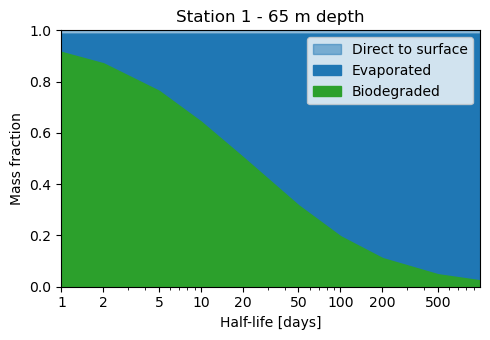

In [8]:
ticks = [1, 2, 5, 10, 20, 50, 100, 200, 500]
title = f'Station {case} - {depth_dict[case]} m depth'
plot_parameter_scan(direct_list, dissolved_list, evaporated_list, biodegraded_list, halflife_days_list, 'Half-life [days]', ticks, title=title)

# Plot ventilation rate

Extract the normalised ventilation rate from the diffusion model output, and plot as a function of time. Ventilation rates are found in Figure 8 in the paper.

In [9]:
##########################
#### Model parameters ####
##########################

# Select station here (1, 2 or 3)
case = 1
# Initial bubble diameter, in meters
d0 = 4.5e-3
# Release depth, in meters (positive downwards)
z0 = depth_dict[case] # Look up depth in dictionary and release from sea floor

# Number of simulations to average over
# (will be evenly spaced throughout the year)
Nruns = 4  # Note: in the paper we used 36

# Diffusion-model timestep, in seconds
dt = 7200  # Note: in the paper we used 1200

##########################
#### Simulation setup ####
##########################

# Load water column data
# (temperature, salinity, diffusivity)
ds = nc.Dataset(f'../data/station{case}/case{case}.nc')

# Note on array slicing below
# Z-coordinates are stored with time dimension, but remain constant, hence leading zero.
# To re-order data to run from surface and down we use ::-1
# The variables have four dimensions, where the last two have length 1, hence the two last zeros.
# The GOTM run was started on December 25, 2018, 00:00 to give some spin-up time
# Slice away the first seven days (hourly output: remove first 7*24 = 168 timesteps)
# And slice away last timestep, which is January 1, 2010, 00:00
skip = 7*24
# Load z-coordinates for cell faces and cell centers
z_gotm  = np.array(np.abs(ds.variables['z' ][0,::-1,0,0]))
zi_gotm = np.array(np.abs(ds.variables['zi'][0,::-1,0,0]))
# Load timestamps for GOTM data
t_gotm  = np.array(ds.variables['time'][skip:-1])
# Reset time to start at zero
t_gotm = t_gotm - t_gotm[0]
# Lead temperature, salinity and diffusivity
T_gotm  = np.array(ds.variables['temp'][skip:-1,::-1,0,0])
S_gotm  = np.array(ds.variables['salt'][skip:-1,::-1,0,0])
K_gotm  = np.array(ds.variables['nus'][ skip:-1,::-1,0,0])

# Load atmosphere data
# We read this from the GOTM input file for convenience
# but it was originally taken from ERA5
# https://doi.org/10.24381/cds.adbb2d47
df_meteo = pd.read_csv(f'../data/station{case}/meteo_file.dat',
                       delim_whitespace=True, index_col=False, parse_dates=[[0,1]],
                       names=['date', 'time', 'u10', 'v10',  'pressure', 'temp', 'humid', 'cloud'])

# Calculate wind speed and mass-transfer coefficient
windspeed = np.sqrt(df_meteo['u10']**2 + df_meteo['v10']**2)
kw = get_kw(windspeed)
# Keep only the values for 2019
mask = (datetime(2019,1,1,0,0) <= df_meteo['date_time'] ) & (df_meteo['date_time'] < datetime(2020,1,1,0,0))
kw = kw[mask].values
# Calculate matching timestamps, in seconds, where t=0 is 2019.00.00 - 00:00
kw_times =  3600 * np.arange(len(kw))


# To find ventilation rate, we don't care about biodegradation,
# choose a very long half-life
halflife = 10*365*24*3600 # 10 years is seconds

# Run ensemble of diffusion solver, with Nrun members    
direct, dissolved, biodegraded, evaporated, tc = run_ensemble(z0, d0, halflife, kw, Nruns, z_gotm, T_gotm, S_gotm, zi_gotm, K_gotm, t_gotm, dt=dt, kw_times=kw_times)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.83s/it]


Text(0, 0.5, 'Ventilation rate [1/day]')

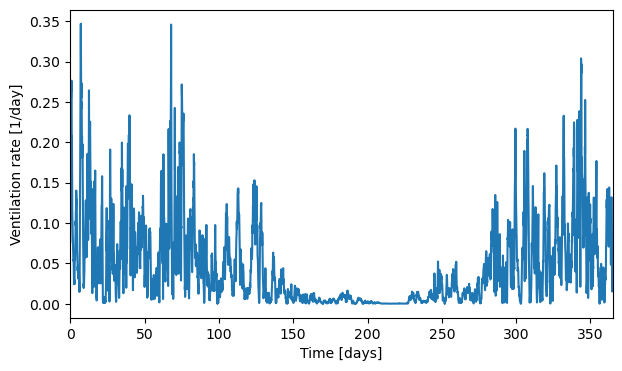

In [10]:
# Differentiate evaporated with respect to time
dEdt = (evaporated[:,1:] - evaporated[:,:-1]) / dt
# Calculate normalised ventilation rate
V = dEdt / dissolved[:,:-1]

# Stack the simulations into an array of length 1 year
Nt = int(365*24*3600 / dt) # Number of timesteps in a year
V_all = np.zeros((Nruns, Nt))
for i in range(Nruns):
    offset = i*int(Nt/Nruns)
    N = Nt - offset
    # First, store data from start to end of first year
    V_all[i,offset:] = V[i,:N]
    # Then, store the remaining timesteps to make up one year,
    # wrapped around onto the beginning of the year
    V_all[i,:offset] = V[i,N:N+offset]

# Take max across runs
Vmax = np.amax(V_all, axis=0)

# Plot results
fig = plt.figure(figsize=(7,4))
# Convert time axis from seconds to days, and
# convert venilation rate units from 1/s to 1/day,
# for easy comparison with biodegradation
plt.plot(tc[0,:Nt] / (24*3600), Vmax * (24*3600))
# Truncate x-axis to 1 year
plt.xlim(0, 365)
plt.xlabel('Time [days]')
plt.ylabel('Ventilation rate [1/day]')